In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
df_train = pd.read_csv('data/sales_train.csv')

In [26]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [27]:
df_train["item_cnt_day"].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

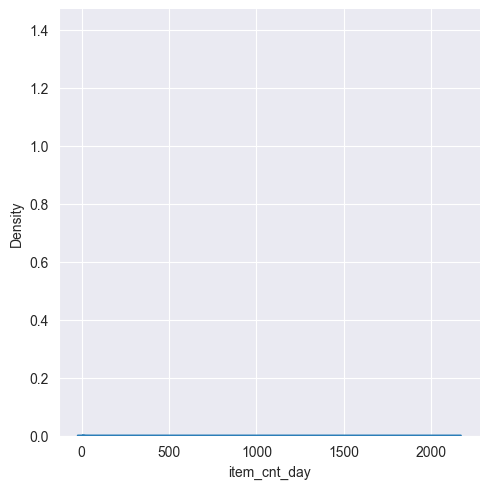

In [35]:
sns.displot(df_train["item_cnt_day"], kde=True, stat="density")

In [29]:
print(f"Skewness: {df_train['item_cnt_day'].skew()}")
print(f"Kurtosis: {df_train['item_cnt_day'].kurt()}")

Skewness: 272.83316168440535
Kurtosis: 177478.0987736997


<Axes: xlabel='date', ylabel='item_cnt_day'>

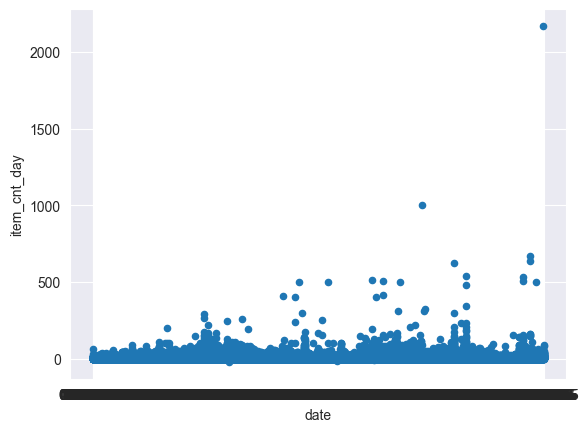

In [49]:
numeric_feature = "date"
data: pd.DataFrame = pd.concat([df_train[numeric_feature], df_train["item_cnt_day"]], axis=1)
data.plot.scatter(x=numeric_feature, y="item_cnt_day")

<Axes: xlabel='date_block_num', ylabel='item_cnt_day'>

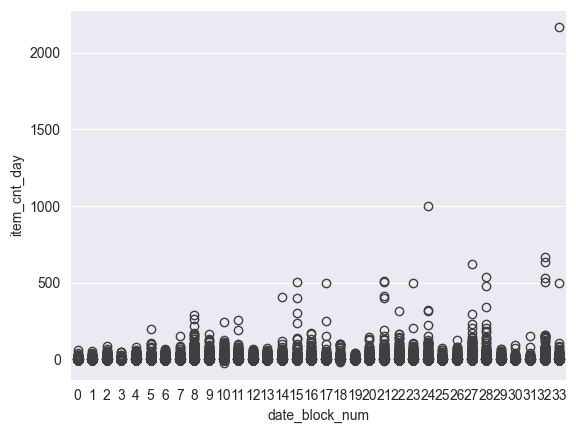

In [48]:
categorical_feature = "date_block_num"
data = pd.concat([df_train[categorical_feature], df_train["item_cnt_day"]], axis=1)
sns.boxplot(x=categorical_feature, y="item_cnt_day", data=data)

<Axes: >

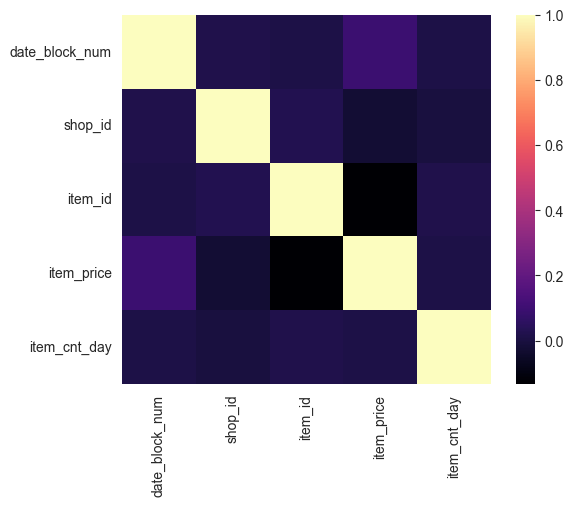

In [64]:
corrmat = df_train.drop(columns=["date"]).corr()
sns.heatmap(corrmat, cmap="magma", square=True)